# Xây dựng Chatbot sử dụng mô hình Sequence2Sequence

In [ ]:
!pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.5 MB/s 
     |████████████████████████████████| 581 kB 44.6 MB/s 
     |████████████████████████████████| 235 kB 51.0 MB/s 
     |████████████████████████████████| 965 kB 43.7 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re,string
from gensim.models import KeyedVectors
from collections import Counter
from underthesea import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from keras.losses import categorical_crossentropy
from keras import utils
from tensorflow.keras import preprocessing, utils, activations
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dữ liệu chatbot question-answer short style.csv')
df.head()

,Unnamed: 0,user_a,user_b
0,0,Thích mẫu người nào,"Dễ thương, tóc dài, da trắng"
1,1,Có crush ai không,Có 1 bạn cùng lớp
2,2,Tại sao lại thích bạn dó,Vì đáp ứng những yêu cầu của tao
3,3,Có hay nói chuyện không,Hay nhắn tin messenger
4,4,Bạn kia có bắt chuyện trước không,Có đôi khi


In [ ]:
df.shape

(5900, 3)

**Text Cleaning / Preprocessing**

In [ ]:
df.isna().sum()

Unnamed: 0    0
user_a        0
user_b        1
dtype: int64

In [ ]:
idx = df[df['user_b'].isnull()].index.tolist() # Get index of nan row
print('Question of nan answer: ' ,df['user_a'][idx].values)

Question of nan answer:  ['Anh chị em làm gì?']


In [ ]:
# Fill in nan row value
df['user_b'] = df['user_b'].fillna('Luật sư').values 

In [ ]:
# Preprocessing
EMOTICONS = { 
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u":))":"Happy face smiley",
    u":)))":"Happy face smiley",
    u":))))":"Happy face smiley",
    u":'<":"Happy face smiley",
    u":)":"Happy face smiley",
    u":(":"Happy face smiley",
    u":((":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u"D:":"Sadness",
    u":O":"Surprise",
    u":o":"Surprise",
}

cnt = Counter()
for text in df["user_b"].values:
    for word in text.split():
        cnt[word] += 1

RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-10-1:-1]]) #Get top 10 rare word

def remove_emoticons(text):
    "Function to remove emoticons"
    arr = [word for word in text.split() if word not in EMOTICONS.keys()]
    return " ".join(arr)

def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

def preprocessing(df): 
  df["user_a"] = df["user_a"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation))) # Remove punctuation
  df["user_b"] = df["user_b"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation))) 
  df["user_a"] = df["user_a"].apply(lambda ele: remove_emoticons(ele)) # Remove emoticons
  df["user_b"] = df["user_b"].apply(lambda ele: remove_emoticons(ele))
  df["user_a"] = df["user_a"].apply(lambda ele: remove_rarewords(ele)) # Remove rarewords
  df["user_b"] = df["user_b"].apply(lambda ele: remove_rarewords(ele))
  df['user_b'] = df['user_b'].apply(lambda ele: 'START ' + ele + ' END')
  df["user_a"] = df["user_a"].apply(lambda ele: ele.lower()) # convert text to lowercase
  df["user_b"] = df["user_b"].apply(lambda ele: ele.lower()) 
  
  return df

df = preprocessing(df)

In [ ]:
data = df.values #numpy 
questions = data[:,1] # convert question to a list
answers = data[:,2] # convert answer that match with question to list
print(questions[:5]) 
print(answers[:5])

['thích mẫu người nào' 'có crush ai không' 'tại sao lại thích bạn dó'
 'có hay nói chuyện không' 'bạn kia có bắt chuyện trước không']
['start dễ thương tóc dài da trắng end' 'start có 1 bạn cùng lớp end'
 'start vì đáp ứng những yêu cầu của tao end'
 'start hay nhắn tin messenger end' 'start có đôi khi end']


**Tokenization and Encode, Decode**

In [ ]:
# Tokenization questions
questions = [word_tokenize(ques) for ques in questions]
print(len(questions))
print(questions[:3])

5900
[['thích', 'mẫu', 'người', 'nào'], ['có', 'crush', 'ai', 'không'], ['tại sao', 'lại', 'thích', 'bạn', 'dó']]


In [ ]:
# Tokenization answer
answers = [word_tokenize(ans) for ans in answers]
print(len(answers))
print(answers[:3])

5900
[['start', 'dễ thương', 'tóc', 'dài', 'da', 'trắng', 'end'], ['start', 'có', '1', 'bạn', 'cùng', 'lớp', 'end'], ['start', 'vì', 'đáp ứng', 'những', 'yêu cầu', 'của', 'tao', 'end']]


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers)
VOCAB_SIZE = len(tokenizer.word_index) + 1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))

VOCAB SIZE : 3644


In [ ]:
word2idx = tokenizer.word_index

In [ ]:
#encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = max([len(x) for x in tokenized_questions])
padded_questions = pad_sequences(tokenized_questions, maxlen = maxlen_questions, padding = 'post')
encoder_input_data = np.array(padded_questions)
print("Max length question:", maxlen_questions)
print(encoder_input_data.shape)

Max length question: 76
(5900, 76)


In [ ]:
# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = max([len(x) for x in tokenized_answers])
padded_answers = pad_sequences(tokenized_answers, maxlen = maxlen_answers, padding='post')
decoder_input_data = np.array(padded_answers)
print("Max length anwser:", maxlen_answers)
print(decoder_input_data.shape)

Max length anwser: 43
(5900, 43)


In [ ]:
# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences(answers)
# Remove Start added before
for i in range(len(tokenized_answers)):
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = pad_sequences(tokenized_answers, maxlen = maxlen_answers, padding='post')
onehot_answers = utils.to_categorical(padded_answers, VOCAB_SIZE)
decoder_output_data = np.array(onehot_answers)
print(decoder_output_data.shape)

(5900, 43, 3644)


**Word2Vec Embedding with FastText**

In [ ]:
fastText_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/wiki.vi.vec')
print("FastText Loaded!")

FastText Loaded!


In [ ]:
embeddings_dim = 300

embedding_matrix = np.zeros((VOCAB_SIZE, embeddings_dim))

for word, index in word2idx.items():
    try:
        embedding_matrix[index,:] = fastText_model[word]
    except:
        continue
        
print(embedding_matrix.shape)

(3644, 300)


**Model Defination**

In [ ]:
# Define Embedding Layer
embedding_layer_question = Embedding(VOCAB_SIZE,embeddings_dim
                                     ,input_length=maxlen_questions
                                     ,weights = [embedding_matrix]
                                     ,trainable=False)

embedding_layer_answer = Embedding(VOCAB_SIZE,embeddings_dim
                                     ,input_length=maxlen_answers
                                     ,weights = [embedding_matrix]
                                     ,trainable=False)

In [ ]:
# Define the model
encoder_inputs = Input(shape = (maxlen_questions, ))
encoder_embedding = embedding_layer_question(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(300,dropout=0.05,return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(maxlen_answers, ))
decoder_embedding = embedding_layer_answer(decoder_inputs)
decoder_lstm = LSTM(300, return_state=True, return_sequences=True,dropout=0.05)
decoder_outputs , _ , _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(VOCAB_SIZE, activation='softmax') 
output = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 76)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 76, 300)      1093200     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 43, 300)      1093200     ['input_2[0][0]']                
                                                                                              

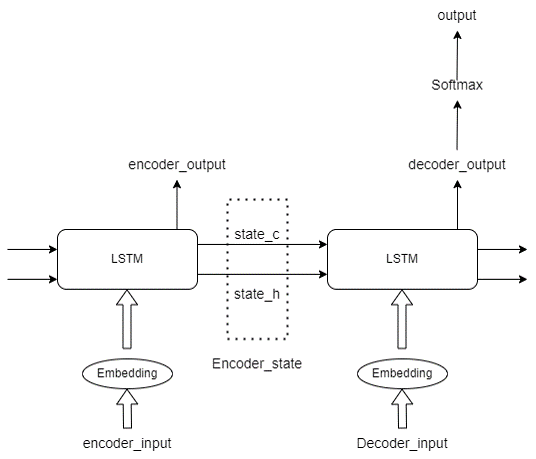

In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='loss', verbose=1, save_best_only=True)

# train model
history = model.fit([encoder_input_data , decoder_input_data], decoder_output_data, batch_size=50, epochs=200) 

2022-05-19 08:24:49.692038: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3697931200 exceeds 10% of free system memory.
2022-05-19 08:24:53.482657: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3697931200 exceeds 10% of free system memory.
2022-05-19 08:24:56.139322: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-05-19 08:24:58.693870: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


118/118 [==============================] - 9s 46ms/step - loss: 1.1024 - acc: 0.9146
Epoch 2/200
118/118 [==============================] - 5s 46ms/step - loss: 0.4781 - acc: 0.9360
Epoch 3/200
118/118 [==============================] - 5s 46ms/step - loss: 0.4609 - acc: 0.9364
Epoch 4/200
118/118 [==============================] - 5s 47ms/step - loss: 0.4488 - acc: 0.9364
Epoch 5/200
118/118 [==============================] - 6s 48ms/step - loss: 0.4385 - acc: 0.9367
Epoch 6/200
118/118 [==============================] - 5s 47ms/step - loss: 0.4283 - acc: 0.9372
Epoch 7/200
118/118 [==============================] - 6s 47ms/step - loss: 0.4183 - acc: 0.9377
Epoch 8/200
118/118 [==============================] - 5s 46ms/step - loss: 0.4089 - acc: 0.9381
Epoch 9/200
118/118 [==============================] - 5s 46ms/step - loss: 0.4003 - acc: 0.9383
Epoch 10/200
118/118 [==============================] - 5s 46ms/step - loss: 0.3917 - acc: 0.9387
Epoch 11/200
118/118 [===================

**Visualize Training Progress**

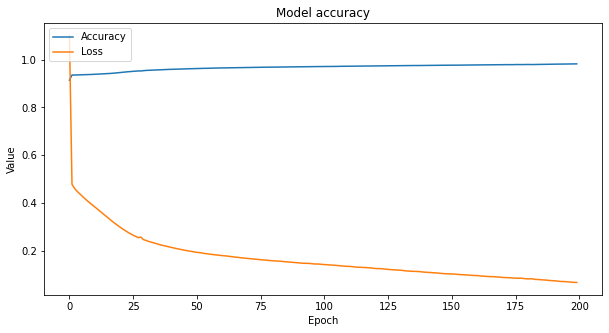

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)
# Plot training accuracy & loss values
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Loss'], loc='upper left')
plt.show()

In [ ]:
model.save_weights('chatbot_weights.h5')

**Defining Inference Models**

In [ ]:
model.load_weights('/content/drive/MyDrive/chatbot_weights.h5')

In [ ]:
def make_inference_models():
    
    encoder_model = Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = Input(shape=(300,))
    decoder_state_input_c = Input(shape=(300,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    
    decoder_states = [state_h, state_c]

    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model, decoder_model

**Bot Chatting**

In [ ]:
def str_to_tokens(sentence):
    words = word_tokenize(sentence.lower())
    tokens_list = []
    
    for word in words:
        tokens_list.append(tokenizer.word_index[word]) 
    return pad_sequences([tokens_list],maxlen = maxlen_questions , padding='post')

In [ ]:
enc_model ,dec_model = make_inference_models()

flag=True
print("BOT: Xin chào! Tôi là ChatBot. Nếu bạn muốn ngưng cuộc trò chuyện, hãy gõ Bye!")

while(flag==True):
    human_response = input('Enter question : ')
    if human_response != 'bye':
        try:
            states_values = enc_model.predict(str_to_tokens(human_response))
            empty_target_seq = np.zeros((1, 1))
            empty_target_seq[0, 0] = word2idx['start']
            stop_condition = False
            decoded_translation = ''
            while not stop_condition:
                dec_outputs, h, c = dec_model.predict([empty_target_seq] + states_values)

                sampled_word_index = np.argmax(dec_outputs[0, -1, :])
                sampled_word = None
                for word, index in word2idx.items() :
                    if sampled_word_index == index:
                        decoded_translation += ' {}'.format(word)
                        sampled_word = word

                if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
                    stop_condition = True

                empty_target_seq = np.zeros((1, 1))  
                empty_target_seq[0 , 0] = sampled_word_index
                states_values = [h, c] 

            print('BOT: ' + decoded_translation.replace("end",""))
        except:
            print("BOT: Xin lỗi câu này tôi chưa đc học ,vui lòng hỏi lại :( ")
    else:
        flag=False
        print("BOT: Tạm biệt nha!")
    

BOT: Xin chào! Tôi là ChatBot. Nếu bạn muốn ngưng cuộc trò chuyện, hãy gõ Bye!
Enter question : người yêu bạn tên gì
BOT:  nguyệt 
Enter question : người yêu bạn học ở trường nào
BOT:  trường đại học buôn ma thuột 
Enter question : bạn đang học ngành gì
BOT:  công nghệ thông tin 
Enter question : bye
BOT: Tạm biệt nha!
